# LSTM for Rare Event Binary Classification


In [47]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import numpy as np
from pylab import rcParams

import tensorflow as tf
from tensorflow.keras import optimizers, Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Dense, LSTM, RepeatVector, TimeDistributed
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_recall_curve
from sklearn.metrics import recall_score, classification_report, auc, roc_curve
from sklearn.metrics import precision_recall_fscore_support, f1_score

from numpy.random import seed
seed(7)
tf.random.set_seed(2)

from sklearn.model_selection import train_test_split

SEED = 123 #used to help randomly select the data points
DATA_SPLIT_PCT = 0.2

rcParams['figure.figsize'] = 8, 6
LABELS = ["Normal","Break"]

In [48]:
df = pd.read_csv("combined_filtered.csv") 
df.head(n=5) 

,Unnamed: 0,_time,GreenRocket,Door1,Door2,LoadCell_R02,Potentiometer_R02,LoadCell_R03,Potentiometer_R03,LoadCell_R04,Potentiometer_R04,Anomally,Success
0,0,2023-09-19T14:21:53.393Z,1,0,0,1857,11866,1693,2390,2640,11855,0,1
1,1,2023-09-19T14:21:53.485Z,1,0,0,1862,11896,1679,2396,2643,11908,0,1
2,2,2023-09-19T14:21:53.582Z,1,0,0,1867,11957,1669,2379,2659,11939,0,1
3,3,2023-09-19T14:21:53.687Z,1,0,0,1886,11955,1699,2403,2612,11932,0,1
4,4,2023-09-19T14:21:53.793Z,1,0,0,1887,11966,1670,2388,2630,11931,0,1


In [49]:
df=df.drop(['Unnamed: 0'], axis=1)
df

,_time,GreenRocket,Door1,Door2,LoadCell_R02,Potentiometer_R02,LoadCell_R03,Potentiometer_R03,LoadCell_R04,Potentiometer_R04,Anomally,Success
0,2023-09-19T14:21:53.393Z,1,0,0,1857,11866,1693,2390,2640,11855,0,1
1,2023-09-19T14:21:53.485Z,1,0,0,1862,11896,1679,2396,2643,11908,0,1
2,2023-09-19T14:21:53.582Z,1,0,0,1867,11957,1669,2379,2659,11939,0,1
3,2023-09-19T14:21:53.687Z,1,0,0,1886,11955,1699,2403,2612,11932,0,1
4,2023-09-19T14:21:53.793Z,1,0,0,1887,11966,1670,2388,2630,11931,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
216029,2023-09-19T20:21:59.584Z,0,0,0,1888,2061,1676,2382,2604,11801,1,0
216030,2023-09-19T20:21:59.686Z,0,0,0,1854,2061,1686,2404,2776,11878,1,0
216031,2023-09-19T20:21:59.785Z,0,0,0,1859,2073,1685,2403,3218,11917,1,0
216032,2023-09-19T20:21:59.887Z,0,0,0,1860,2067,1655,2385,2176,11904,1,0


In [50]:
df=df.drop(['Success'], axis=1)

In [3]:
df['Anomally'] = df['Anomally'].replace({'N': 0, 'Y': 1})
df
df=df.rename(columns={"Success?": "Success"})

df['Success'] = df['Success'].replace({'N': 0, 'Y': 1})
df

,Unnamed: 0,_time,VFD1,VFD2,VFD3,VFD4,Success,Anomally,Description,Cycle_Number,...,TJointAngle_R03,UJointAngle_R03,LoadCell_R04,Potentiometer_R04,BJointAngle_R04,LJointAngle_R04,RJointAngle_R04,SJointAngle_R04,TJointAngle_R04,UJointAngle_R04
0,0,2023-09-19T14:21:53.393Z,32.065132,89.130089,77.845947,-2.330000e-09,1,0,NaN,1.0,...,0.002151,0.0,2640,11855,-0.005493,0.781131,0.0,-90.0,-0.002151,0.786621
1,1,2023-09-19T14:21:53.485Z,32.065132,89.130089,77.630096,7.803271e+01,1,0,NaN,1.0,...,0.002151,0.0,2643,11908,-0.005493,0.781131,0.0,-90.0,-0.002151,0.786621
2,2,2023-09-19T14:21:53.582Z,32.065132,89.130089,77.630096,7.803271e+01,1,0,NaN,1.0,...,0.002151,0.0,2659,11939,-0.005493,0.781131,0.0,-90.0,-0.002151,0.786621
3,3,2023-09-19T14:21:53.687Z,32.065132,89.130089,77.630096,7.803271e+01,1,0,NaN,1.0,...,0.002151,0.0,2612,11932,-0.005493,0.781131,0.0,-90.0,-0.002151,0.786621
4,4,2023-09-19T14:21:53.793Z,32.065132,89.130089,77.630096,7.803271e+01,1,0,NaN,1.0,...,0.002151,0.0,2630,11931,-0.005493,0.781131,0.0,-90.0,-0.002151,0.786621
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
211540,211540,2023-09-19T20:14:30.591Z,32.065441,131.260925,102.130470,1.028948e+02,1,1,BothBodies and Nose Removed,71.0,...,-0.002151,0.0,2959,11864,-0.005493,0.781131,0.0,-90.0,0.000000,0.786621
211541,211541,2023-09-19T20:14:30.691Z,32.065441,131.260925,102.130470,1.029058e+02,1,1,BothBodies and Nose Removed,71.0,...,-0.002151,0.0,3221,11966,-0.005493,0.781131,0.0,-90.0,0.000000,0.786621
211542,211542,2023-09-19T20:14:30.787Z,32.065441,131.260925,102.130470,1.029167e+02,1,1,BothBodies and Nose Removed,71.0,...,-0.002151,0.0,2467,11801,-0.005493,0.781131,0.0,-90.0,0.000000,0.786621
211543,211543,2023-09-19T20:14:30.883Z,32.065441,131.260925,102.130470,1.029277e+02,1,1,BothBodies and Nose Removed,71.0,...,-0.002151,0.0,3176,11923,-0.005493,0.781131,0.0,-90.0,0.000000,0.786621


In [5]:
sign = lambda x: (1, -1)[x < 0]

def curve_shift(df, shift_by):
    vector = df['Anomally'].copy()
    for s in range(abs(shift_by)):
        tmp = vector.shift(sign(shift_by))
        tmp = tmp.fillna(0)
        vector += tmp
    labelcol = 'Anomally'
    # Add vector to the df
    df.insert(loc=0, column=labelcol+'tmp', value=vector)
    # Remove the rows with labelcol == 1.
    df = df.drop(df[df[labelcol] == 1].index)
    # Drop labelcol and rename the tmp col as labelcol
    df = df.drop(labelcol, axis=1)
    df = df.rename(columns={labelcol+'tmp': labelcol})
    # Make the labelcol binary
    df.loc[df[labelcol] > 0, labelcol] = 1

    return df

In [6]:
'''
Shift the data by 2 units, equal to 4 minutes.

Test: Testing whether the shift happened correctly.
'''
print('Before shifting')  # Positive labeled rows before shifting.
one_indexes = df.index[df['Anomally'] == 1]
display(df.iloc[(one_indexes[0]-3):(one_indexes[0]+2), 0:5].head(n=5))

# Shift the response column y by 2 rows to do a 4-min ahead prediction.
df = curve_shift(df, shift_by = -2)

print('After shifting')  # Validating if the shift happened correctly.
display(df.iloc[(one_indexes[0]-4):(one_indexes[0]+1), 0:5].head(n=5))  

Before shifting


,_time,GreenRocket,Door1,Door2,LoadCell_R02
15744,2023-09-19T14:48:07.791Z,0,0,0,1868
15745,2023-09-19T14:48:08.127Z,0,0,0,1882
15746,2023-09-19T14:48:08.128Z,0,0,0,1871
15747,2023-09-19T14:48:08.130Z,0,0,1,1866
15748,2023-09-19T14:48:08.181Z,0,0,1,1883


After shifting


,Anomally,_time,GreenRocket,Door1,Door2
15743,0.0,2023-09-19T14:48:07.673Z,0,0,0
15744,0.0,2023-09-19T14:48:07.791Z,0,0,0
15745,1.0,2023-09-19T14:48:08.127Z,0,0,0
15746,1.0,2023-09-19T14:48:08.128Z,0,0,0
15852,0.0,2023-09-19T14:48:18.579Z,0,0,0


In [7]:
# Remove time column, and the categorical columns
df = df.drop(['_time'], axis=1)

In [8]:
df

,Anomally,GreenRocket,Door1,Door2,LoadCell_R02,Potentiometer_R02,LoadCell_R03,Potentiometer_R03,LoadCell_R04,Potentiometer_R04
0,0.0,1,0,0,1857,11866,1693,2390,2640,11855
1,0.0,1,0,0,1862,11896,1679,2396,2643,11908
2,0.0,1,0,0,1867,11957,1669,2379,2659,11939
3,0.0,1,0,0,1886,11955,1699,2403,2612,11932
4,0.0,1,0,0,1887,11966,1670,2388,2630,11931
...,...,...,...,...,...,...,...,...,...,...
188882,0.0,0,0,0,1873,11974,1703,2403,2736,11956
188883,0.0,0,0,0,1893,11928,1673,2379,2621,11827
188884,0.0,0,0,0,1883,11919,1715,2408,2696,11907
188885,1.0,0,0,0,1840,11907,1695,2398,2643,11873


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 181846 entries, 0 to 188886
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Anomally           181846 non-null  float64
 1   GreenRocket        181846 non-null  int64  
 2   Door1              181846 non-null  int64  
 3   Door2              181846 non-null  int64  
 4   LoadCell_R02       181846 non-null  int64  
 5   Potentiometer_R02  181846 non-null  int64  
 6   LoadCell_R03       181846 non-null  int64  
 7   Potentiometer_R03  181846 non-null  int64  
 8   LoadCell_R04       181846 non-null  int64  
 9   Potentiometer_R04  181846 non-null  int64  
dtypes: float64(1), int64(9)
memory usage: 15.3 MB


In [10]:
input_X = df.loc[:, df.columns != 'Anomally'].values  # converts the df to a numpy array
input_y = df['Anomally'].values

n_features = input_X.shape[1]  # number of features

In [11]:
n_features

9

In [12]:
input_y

array([0., 0., 0., ..., 0., 1., 1.])

In [13]:
input_X

array([[    1,     0,     0, ...,  2390,  2640, 11855],
       [    1,     0,     0, ...,  2396,  2643, 11908],
       [    1,     0,     0, ...,  2379,  2659, 11939],
       ...,
       [    0,     0,     0, ...,  2408,  2696, 11907],
       [    0,     0,     0, ...,  2398,  2643, 11873],
       [    0,     0,     0, ...,  2393,  2765, 11962]])

In [14]:
n_features

9

In [15]:
def temporalize(X, y, lookback):
    output_X = []
    output_y = []
    for i in range(len(X)-lookback-1):
        t = []
        for j in range(1,lookback+1):
            # Gather past records upto the lookback period
            t.append(X[[(i+j+1)], :])
        output_X.append(t)
        output_y.append(y[i+lookback+1])
    return output_X, output_y

In [16]:
'''
Test: The 3D tensors (arrays) for LSTM are forming correctly.
'''
print('First instance of y = 1 in the original data')
display(df.iloc[(np.where(np.array(input_y) == 1)[0][0]-5):(np.where(np.array(input_y) == 1)[0][0]+1), ])

lookback = 5  # Equivalent to 10 min of past data.
# Temporalize the data
X, y = temporalize(X = input_X, y = input_y, lookback = lookback)

print('For the same instance of y = 1, we are keeping past 5 samples in the 3D predictor array, X.')
display(pd.DataFrame(np.concatenate(X[np.where(np.array(y) == 1)[0][0]], axis=0 ))) 

First instance of y = 1 in the original data


,Anomally,GreenRocket,Door1,Door2,LoadCell_R02,Potentiometer_R02,LoadCell_R03,Potentiometer_R03,LoadCell_R04,Potentiometer_R04
15740,0.0,0,0,0,1873,11895,10538,12344,2832,12010
15741,0.0,0,0,0,1865,11872,10533,12345,3073,11898
15742,0.0,0,0,0,1856,11911,10587,12388,2813,11884
15743,0.0,0,0,0,1836,11888,10532,12337,2829,11861
15744,0.0,0,0,0,1868,11951,10616,12463,2693,11957
15745,1.0,0,0,0,1882,11949,10587,12415,2644,11762


For the same instance of y = 1, we are keeping past 5 samples in the 3D predictor array, X.


,0,1,2,3,4,5,6,7,8
0,0,0,0,1865,11872,10533,12345,3073,11898
1,0,0,0,1856,11911,10587,12388,2813,11884
2,0,0,0,1836,11888,10532,12337,2829,11861
3,0,0,0,1868,11951,10616,12463,2693,11957
4,0,0,0,1882,11949,10587,12415,2644,11762


In [17]:
X_train, X_test, y_train, y_test = train_test_split(np.array(X), np.array(y), test_size=DATA_SPLIT_PCT, random_state=SEED)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=DATA_SPLIT_PCT, random_state=SEED)


In [18]:
X_train.shape

(116377, 5, 1, 9)

In [19]:
np.array(y)

array([0., 0., 0., ..., 0., 1., 1.])

In [20]:
X_train_y0 = X_train[y_train==0]
X_train_y1 = X_train[y_train==1]

X_valid_y0 = X_valid[y_valid==0]
X_valid_y1 = X_valid[y_valid==1]

In [21]:
X_train_y0.shape

(116363, 5, 1, 9)

In [22]:
X_valid_y0.shape

(29093, 5, 1, 9)

#### Reshaping the data
The tensors we have here are 4-dimensional. We will reshape them into the desired 3-dimensions corresponding to sample x lookback x features.

In [23]:
X_train = X_train.reshape(X_train.shape[0], lookback, n_features)
X_train_y0 = X_train_y0.reshape(X_train_y0.shape[0], lookback, n_features)
X_train_y1 = X_train_y1.reshape(X_train_y1.shape[0], lookback, n_features)

X_test = X_test.reshape(X_test.shape[0], lookback, n_features)

X_valid = X_valid.reshape(X_valid.shape[0], lookback, n_features)
X_valid_y0 = X_valid_y0.reshape(X_valid_y0.shape[0], lookback, n_features)
X_valid_y1 = X_valid_y1.reshape(X_valid_y1.shape[0], lookback, n_features)

In [24]:
def flatten(X):
    '''
    Flatten a 3D array.
    
    Input
    X            A 3D array for lstm, where the array is sample x timesteps x features.
    
    Output
    flattened_X  A 2D array, sample x features.
    '''
    flattened_X = np.empty((X.shape[0], X.shape[2]))  # sample x features array.
    for i in range(X.shape[0]):
        flattened_X[i] = X[i, (X.shape[1]-1), :]
    return(flattened_X)

def scale(X, scaler):
    '''
    Scale 3D array.

    Inputs
    X            A 3D array for lstm, where the array is sample x timesteps x features.
    scaler       A scaler object, e.g., sklearn.preprocessing.StandardScaler, sklearn.preprocessing.normalize
    
    Output
    X            Scaled 3D array.
    '''
    for i in range(X.shape[0]):
        X[i, :, :] = scaler.transform(X[i, :, :])
        
    return X

In [25]:
# Initialize a scaler using the training data.
scaler = StandardScaler().fit(flatten(X_train_y0))

In [26]:
X_train_y0_scaled = scale(X_train_y0, scaler)
X_train_y1_scaled = scale(X_train_y1, scaler)
X_train_scaled = scale(X_train, scaler)

In [27]:
'''
Test: Check if the scaling is correct.

The test succeeds if all the column means 
and variances are 0 and 1, respectively, after
flattening.
'''
a = flatten(X_train_y0_scaled)
print('colwise mean', np.mean(a, axis=0).round(6))
print('colwise variance', np.var(a, axis=0))

colwise mean [ 0.136977  0.        0.       -0.009685 -0.250913  0.259318  0.251051
  0.155702 -0.266786]
colwise variance [0.94007314 0.         0.         0.46490796 0.43837896 0.68552791
 0.41560512 0.73099683 0.49464091]


In [28]:
X_valid_scaled = scale(X_valid, scaler)
X_valid_y0_scaled = scale(X_valid_y0, scaler)

X_test_scaled = scale(X_test, scaler)

# LSTM training

In [32]:
timesteps =  X_train_y0_scaled.shape[1] # equal to the lookback
n_features =  X_train_y0_scaled.shape[2] # 59

epochs = 100
batch = 32
lr = 0.0001

In [33]:
lstm = Sequential()
lstm.add(LSTM(32, activation='relu', input_shape=(timesteps, n_features), return_sequences=True))
lstm.add(LSTM(100, activation='relu', return_sequences=True))
lstm.add(LSTM(150, activation='relu', return_sequences=True))
lstm.add(LSTM(200, activation='relu', return_sequences=True))
lstm.add(LSTM(32, activation='relu', return_sequences=True))
lstm.add(TimeDistributed(Dense(n_features)))
lstm.compile(optimizer='adam', loss='mse')

lstm.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_7 (LSTM)               (None, 5, 32)             5376      
                                                                 
 lstm_8 (LSTM)               (None, 5, 100)            53200     
                                                                 
 lstm_9 (LSTM)               (None, 5, 150)            150600    
                                                                 
 lstm_10 (LSTM)              (None, 5, 200)            280800    
                                                                 
 lstm_11 (LSTM)              (None, 5, 32)             29824     
                                                                 
 time_distributed_1 (TimeDis  (None, 5, 9)             297       
 tributed)                                                       
                                                      

In [34]:
adam = optimizers.Adam(lr)
lstm.compile(loss='mse', optimizer=adam)

cp = ModelCheckpoint(filepath="lstm_classifier_mcnair.h5",
                               save_best_only=True,
                               verbose=0)

tb = TensorBoard(log_dir='./logs',
                histogram_freq=0,
                write_graph=True,
                write_images=True)

lstm_history = lstm.fit(X_train_y0_scaled, X_train_y0_scaled, 
                                                epochs=epochs, 
                                                batch_size=batch, 
                                                validation_data=(X_valid_y0_scaled, X_valid_y0_scaled),
                                                verbose=2).history

Epoch 1/100
3637/3637 - 51s - loss: 0.1672 - val_loss: 0.0665 - 51s/epoch - 14ms/step
Epoch 2/100
3637/3637 - 50s - loss: 0.0486 - val_loss: 0.0295 - 50s/epoch - 14ms/step
Epoch 3/100
3637/3637 - 47s - loss: 0.0193 - val_loss: 0.0090 - 47s/epoch - 13ms/step
Epoch 4/100
3637/3637 - 47s - loss: 0.0042 - val_loss: 0.0025 - 47s/epoch - 13ms/step
Epoch 5/100
3637/3637 - 47s - loss: 0.0017 - val_loss: 0.0014 - 47s/epoch - 13ms/step
Epoch 6/100
3637/3637 - 47s - loss: 0.0011 - val_loss: 8.6849e-04 - 47s/epoch - 13ms/step
Epoch 7/100
3637/3637 - 47s - loss: 7.8796e-04 - val_loss: 6.9395e-04 - 47s/epoch - 13ms/step
Epoch 8/100
3637/3637 - 47s - loss: 6.3498e-04 - val_loss: 4.7280e-04 - 47s/epoch - 13ms/step
Epoch 9/100
3637/3637 - 47s - loss: 4.5111e-04 - val_loss: 4.3967e-04 - 47s/epoch - 13ms/step
Epoch 10/100
3637/3637 - 47s - loss: 3.6701e-04 - val_loss: 3.3132e-04 - 47s/epoch - 13ms/step
Epoch 11/100
3637/3637 - 47s - loss: 3.1980e-04 - val_loss: 2.3988e-04 - 47s/epoch - 13ms/step
Epoch 12

Epoch 88/100
3637/3637 - 47s - loss: 1.5658e-05 - val_loss: 9.9688e-06 - 47s/epoch - 13ms/step
Epoch 89/100
3637/3637 - 48s - loss: 1.5614e-05 - val_loss: 1.0786e-05 - 48s/epoch - 13ms/step
Epoch 90/100
3637/3637 - 47s - loss: 1.5593e-05 - val_loss: 1.3455e-05 - 47s/epoch - 13ms/step
Epoch 91/100
3637/3637 - 173s - loss: 1.5228e-05 - val_loss: 1.4443e-05 - 173s/epoch - 48ms/step
Epoch 92/100
3637/3637 - 865s - loss: 1.4317e-05 - val_loss: 8.3843e-06 - 865s/epoch - 238ms/step
Epoch 93/100
3637/3637 - 48s - loss: 1.7743e-05 - val_loss: 1.0377e-04 - 48s/epoch - 13ms/step
Epoch 94/100
3637/3637 - 47s - loss: 1.2324e-05 - val_loss: 8.4875e-06 - 47s/epoch - 13ms/step
Epoch 95/100
3637/3637 - 48s - loss: 1.6410e-05 - val_loss: 1.4391e-05 - 48s/epoch - 13ms/step
Epoch 96/100
3637/3637 - 47s - loss: 1.4758e-05 - val_loss: 3.1480e-05 - 47s/epoch - 13ms/step
Epoch 97/100
3637/3637 - 47s - loss: 1.4355e-05 - val_loss: 1.6069e-05 - 47s/epoch - 13ms/step
Epoch 98/100
3637/3637 - 47s - loss: 1.5117e-

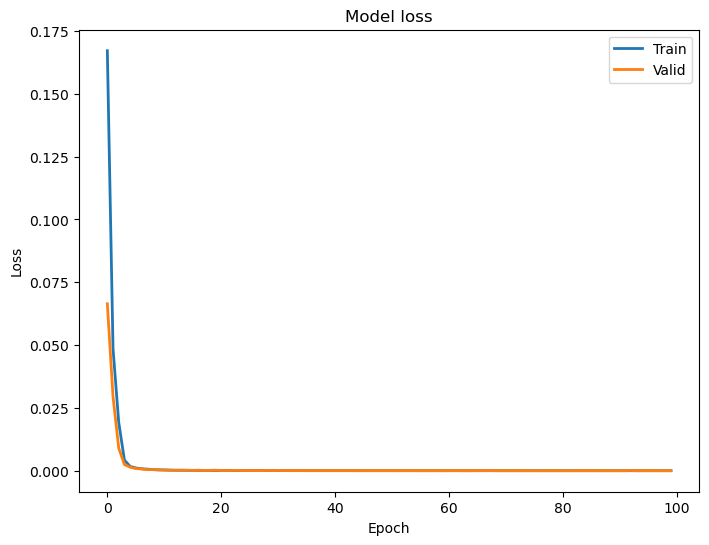

In [35]:
plt.plot(lstm_history['loss'], linewidth=2, label='Train')
plt.plot(lstm_history['val_loss'], linewidth=2, label='Valid')
plt.legend(loc='upper right')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

3637/3637 [==============================] - 19s 5ms/step


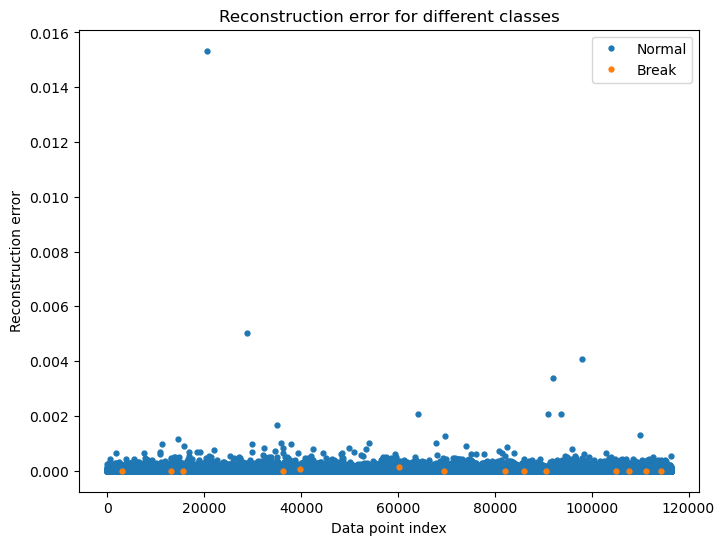

In [36]:
train_x_predictions = lstm.predict(X_train_scaled)
mse = np.mean(np.power(flatten(X_train_scaled) - flatten(train_x_predictions), 2), axis=1)

error_df = pd.DataFrame({'Reconstruction_error': mse,
                        'True_class': y_train.tolist()})

groups = error_df.groupby('True_class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.Reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Break" if name == 1 else "Normal")
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

## Predictions using the lstm

910/910 [==============================] - 4s 5ms/step


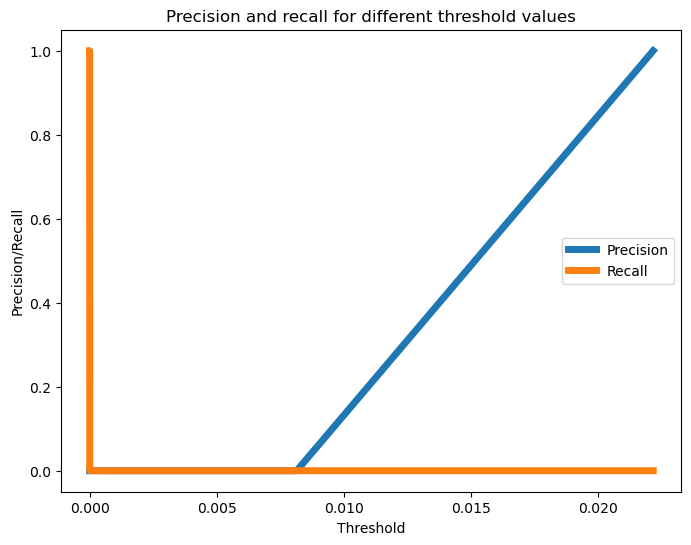

In [37]:
valid_x_predictions = lstm.predict(X_valid_scaled)
mse = np.mean(np.power(flatten(X_valid_scaled) - flatten(valid_x_predictions), 2), axis=1)

error_df = pd.DataFrame({'Reconstruction_error': mse,
                        'True_class': y_valid.tolist()})

precision_rt, recall_rt, threshold_rt = precision_recall_curve(error_df.True_class, error_df.Reconstruction_error)
plt.plot(threshold_rt, precision_rt[1:], label="Precision",linewidth=5)
plt.plot(threshold_rt, recall_rt[1:], label="Recall",linewidth=5)
plt.title('Precision and recall for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision/Recall')
plt.legend()
plt.show()

1137/1137 [==============================] - 6s 5ms/step


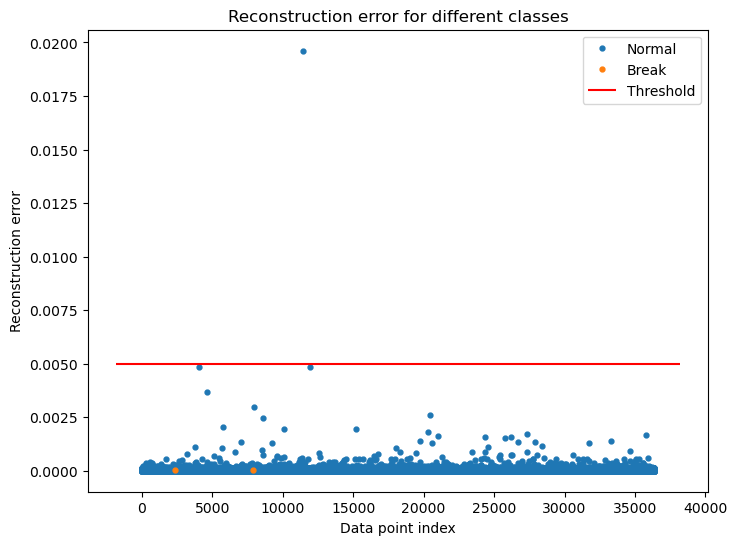

In [41]:
test_x_predictions = lstm.predict(X_test_scaled)
mse = np.mean(np.power(flatten(X_test_scaled) - flatten(test_x_predictions), 2), axis=1)

error_df = pd.DataFrame({'Reconstruction_error': mse,
                        'True_class': y_test.tolist()})

threshold_fixed = 0.005
groups = error_df.groupby('True_class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.Reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Break" if name == 1 else "Normal")
ax.hlines(threshold_fixed, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

In [42]:
pred_y = [1 if e > threshold_fixed else 0 for e in error_df.Reconstruction_error.values]

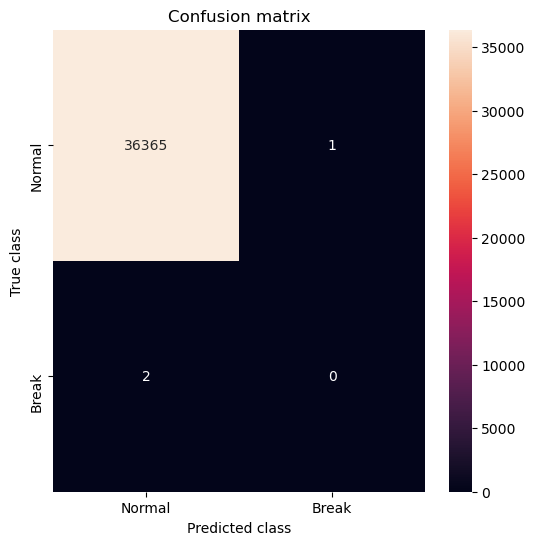

In [43]:
conf_matrix = confusion_matrix(error_df.True_class, pred_y)

plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

In [44]:
target_names = ['Normal', 'Break']

print(classification_report(error_df.True_class, pred_y, target_names=target_names))

              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00     36366
       Break       0.00      0.00      0.00         2

    accuracy                           1.00     36368
   macro avg       0.50      0.50      0.50     36368
weighted avg       1.00      1.00      1.00     36368



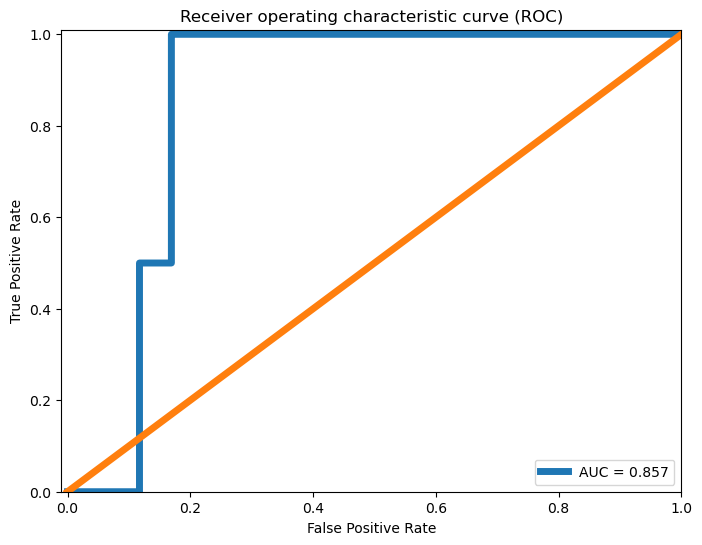

In [46]:
false_pos_rate, true_pos_rate, thresholds = roc_curve(error_df.True_class, error_df.Reconstruction_error)
roc_auc = auc(false_pos_rate, true_pos_rate,)

plt.plot(false_pos_rate, true_pos_rate, linewidth=5, label='AUC = %0.3f'% roc_auc)
plt.plot([0,1],[0,1], linewidth=5)

plt.xlim([-0.01, 1])
plt.ylim([0, 1.01])
plt.legend(loc='lower right')
plt.title('Receiver operating characteristic curve (ROC)')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()